In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import datetime

Here's some text about what we need to do.

### Import data from BigQuery

In [22]:
sql = """
WITH 
  price_concession AS (--subquery to remove duplicates due to different pack sizes
  SELECT
    ncso.date AS month, --month
    ncso.drug AS name,  -- drug name
    vmpp.bnf_code AS bnf_code, --BNF code from VMPP table
    ncso.price_pence AS pc_price_pence, --price concession cost per pack
    dt.price_pence AS dt_price_pence, --Drug Tariff cost per pack
    qtyval, --VMPP pack size
    (ncso.price_pence - dt.price_pence)/qtyval AS increased_ppu --difference between concession and usual Drug Tariff price
  FROM
    ebmdatalab.dmd.ncsoconcession AS ncso --concession table
  INNER JOIN
    dmd.vmpp_full AS vmpp --VMPP table
  ON
    ncso.vmpp = vmpp.id
  INNER JOIN
    dmd.tariffprice AS dt -- Drug Tariff table
  ON
    ncso.vmpp = dt.vmpp
    AND ncso.date = dt.date
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ncso.date, vmpp.bnf_code ORDER BY (ncso.price_pence - dt.price_pence)/qtyval DESC) = 1 -- for each bnf_code and pack size, calculates PPU difference and ranks in order. Takes the top value, therefore only keeping the highest impact pack size, and thereby removes duplicates for pack size
  ORDER BY
    ncso.date,
    vmpp.bnf_code),
  rx_data AS (--subquery to create prescribing calculations)
  SELECT
    rx.month AS month,
    bnf_name,
    bnf_code AS bnf_code,
    SUM(quantity) AS quantity,
    SUM(net_cost) AS nic,
    SUM(actual_cost) AS actual_cost
  FROM
    ebmdatalab.hscic.normalised_prescribing AS rx
  GROUP BY
    rx.month,
    bnf_name,
    bnf_code)

#main query

SELECT
  rx.month,
  rx.bnf_name,
  rx.bnf_code,
  rx.quantity AS quantity,
  #rx_old.quantity AS quantity_2_months_previously ,
  rx.nic,
  rx.actual_cost,
  dt_price_pence/(100*qtyval) AS normal_actual_cost_per_unit, --calculates "normal" drug tariff price per unit
  pc_price_pence/(100*qtyval) AS predicted_actual_cost_per_unit -- calculates price concession predicted cost per unit
FROM
  rx_data AS rx
#INNER JOIN
#  rx_data AS rx_old -- data from two months previously
#ON
#  rx.bnf_code = rx_old.bnf_code
#  AND DATE(rx.month) = DATE_ADD(DATE(rx_old.month), INTERVAL 2 month) -- join to create data from two months ago
INNER JOIN
  price_concession AS ncso
ON
  DATE(rx.month) = ncso.month
  AND rx.bnf_code = ncso.bnf_code
ORDER BY
  rx.month
"""

exportfile = os.path.join("..","data","ncso_df.csv")
ncso_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True)
ncso_df['month'] = ncso_df['month'].astype('datetime64[ns]')

Downloading: 100%|██████████| 4369/4369 [00:00<00:00, 6513.64rows/s]


In [23]:
ncso_df.head()
#max(ncso_df['month'])

,month,bnf_name,bnf_code,quantity,nic,actual_cost,normal_actual_cost_per_unit,predicted_actual_cost_per_unit
0,2014-08-01,Hydrocortisone 10mg tablets,0603020J0AAADAD,1853682.0,3617621.72,3.349338e+06,1.715333333,1.950666667
1,2014-08-01,Valsartan 40mg capsules,0205052V0AAAAAA,270796.0,82208.67,7.622176e+04,0.0575,0.303571429
2,2014-08-01,Co-amilofruse 2.5mg/20mg tablets,0202040B0AAABAB,454860.0,70254.54,6.552452e+04,0.043571429,0.154285714
3,2014-08-01,Pizotifen 500microgram tablets,0407042Q0AAABAB,1260033.0,312792.43,2.902923e+05,0.040357143,0.248214286
4,2014-08-01,Fenofibrate micronised 200mg capsules,0212000P0AAABAB,454336.0,230815.01,2.139494e+05,0.070357143,0.508214286


In [24]:
op_df = pd.read_csv(os.path.join("..","data","price-concessions-cost-nhs-england-2022-07-01.csv"))
ncso_jul_22_df = ncso_df[ncso_df['month'].dt.strftime('%Y-%m-%d') == "2022-07-01"]
check_ncso_jul_df = pd.merge(ncso_jul_22_df, op_df, left_on='bnf_code', right_on='BNF code')
check_ncso_jul_df = check_ncso_jul_df[['bnf_name','bnf_code','quantity', 'Quantity']]
check_ncso_jul_df = check_ncso_jul_df.rename(columns={"quantity": "bq_quantity", "Quantity": "op_quantity"})
check_ncso_jul_df["difference"] = check_ncso_jul_df["bq_quantity"] - check_ncso_jul_df["op_quantity"]
check_ncso_jul_df = check_ncso_jul_df.sort_values(by=['difference'])
exportfile = os.path.join("..","data","july_difference.csv")
check_ncso_jul_df.to_csv(exportfile, index=False)

In [92]:
op_df = pd.read_csv(os.path.join("..","data","price-concessions-cost-nhs-england-2022-06-01.csv"))
ncso_jun_22_df = ncso_df[ncso_df['month'].dt.strftime('%Y-%m-%d') == "2022-06-01"]
check_ncso_jun_df = pd.merge(ncso_jun_22_df, op_df, left_on='bnf_code', right_on='BNF code')
check_ncso_jun_df = check_ncso_jun_df[['bnf_name','bnf_code','quantity', 'Quantity']]
check_ncso_jun_df = check_ncso_jun_df.rename(columns={"quantity": "bq_quantity", "Quantity": "op_quantity"})
check_ncso_jun_df["difference"] = check_ncso_jun_df["bq_quantity"] - check_ncso_jun_df["op_quantity"]
check_ncso_jun_df = check_ncso_jun_df.sort_values(by=['difference'])
exportfile = os.path.join("..","data","june_difference.csv")
check_ncso_jun_df.to_csv(exportfile, index=False)

In [69]:
#eck_ncso_list_df.sort_values(by=['difference'])
#check_ncso_list_df.head()
check_ncso_list_df.to_csv(index=False)

TypeError: 'str' object is not callable

In [4]:
ncso_sum_df=ncso_df.groupby(['month',])[['actual_cost','predicted_actual_cost']].sum()  #group data to show total per month
#ncso_sum_df['predicted_actual_cost'] = ncso_sum_df['predicted_NIC'] * 0.928
ncso_sum_df['difference'] = ncso_sum_df['predicted_actual_cost'] - ncso_sum_df['actual_cost']  #calculate difference between predicted and actual
ncso_sum_df['perc_difference'] = ncso_sum_df['difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference
ncso_sum_df.sort_values(by=['month']) #sort values by month for chart

,actual_cost,predicted_actual_cost,difference,perc_difference
month,,,,
2014-08-01,6.588830e+06,6.626347e+06,3.751708e+04,0.005694
2014-09-01,6.462055e+06,6.735585e+06,2.735292e+05,0.042329
2014-10-01,2.426580e+06,2.295782e+06,-1.307982e+05,-0.053902
2014-11-01,2.425360e+06,2.594481e+06,1.691203e+05,0.069730
2014-12-01,2.872393e+06,2.867081e+06,-5.311248e+03,-0.001849
...,...,...,...,...
2022-03-01,2.180165e+07,2.008474e+07,-1.716916e+06,-0.078752
2022-04-01,2.083365e+07,1.927074e+07,-1.562913e+06,-0.075019
2022-05-01,2.502535e+07,2.501500e+07,-1.035325e+04,-0.000414


In [11]:
ncso_sum_df.head()

,nic,actual_cost,predicted_actual_cost
month,,,
2014-08-01,7107643.40,6.588830e+06,6.626347e+06
2014-09-01,6977951.07,6.462055e+06,6.735585e+06
2014-10-01,2621980.73,2.426580e+06,2.295782e+06
2014-11-01,2616743.92,2.425360e+06,2.594481e+06
2014-12-01,3101960.84,2.872393e+06,2.867081e+06


In [ ]:
ncso_sum_df.reset_index(inplace=True)

In [ ]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y= ['perc_difference'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [17]:
ncso_sum_df['perc_difference'].std()

0.060080454874278384

In [8]:
ncso_df.head()

,month,bnf_name,bnf_code,quantity,quantity_2_months_previously,nic,actual_cost,predicted_actual_cost
0,2014-08-01,Naproxen 500mg gastro-resistant tablets,1001010P0AAAIAI,3137978.0,3196175.0,565617.50,524972.57358,534948.375714
1,2014-08-01,Co-amilofruse 2.5mg/20mg tablets,0202040B0AAABAB,454860.0,477859.0,70254.54,65524.52257,68418.486309
2,2014-08-01,Cefalexin 500mg/5ml oral suspension,0501021L0AAAEAE,37900.0,44000.0,2402.09,2226.61813,2588.748800
3,2014-08-01,Pizotifen 1.5mg tablets,0407042Q0AAACAC,816590.0,832282.0,202720.36,188144.61809,191710.213829
4,2014-08-01,Exemestane 25mg tablets,0803041C0AAAAAA,303755.0,303478.0,61003.08,56885.49106,55762.261632


### How could we get more accuracy?

In [128]:
# import bank holidays json (2012-2020)
#from pandas.io.json import json_normalize #package for flattening json in pandas df

In [129]:
# load bank holidays json and pass to busdays function `holidays=[]` ###
url = 'https://www.gov.uk/bank-holidays.json'
bh = pd.read_json(url, orient='index')
# separate out the embedded json 
#flattening json in pandas df
bankhols = pd.json_normalize(bh.iloc[0]["events"])
bankhols.head()

,title,date,notes,bunting
0,New Year’s Day,2017-01-02,Substitute day,True
1,Good Friday,2017-04-14,,False
2,Easter Monday,2017-04-17,,True
3,Early May bank holiday,2017-05-01,,True
4,Spring bank holiday,2017-05-29,,True


In [130]:
ncso_dates_df=ncso_sum_df.reset_index()

In [131]:
import calendar
dates = ncso_dates_df[["rx_month"]].drop_duplicates()
dates["rx_month"] = pd.to_datetime(dates["rx_month"])
dates["year"] = dates["rx_month"].dt.year
dates["mon"] = dates["rx_month"].dt.month
d = []
for row in dates.itertuples():
    y = row.year
    m = row.mon
    day = calendar.monthrange(y,m)[1]
    d.append(str(y)+"-"+str(m)+"-"+str(day))
d = pd.Series(d, name="enddates")
d = pd.to_datetime(d, format="%Y/%m/%d")
begindates = pd.Series(dates["rx_month"]).values.astype('datetime64[D]')
enddates = pd.Series(d).values.astype('datetime64[D]')
#######
# find business days in month
dates["workdays"] = np.busday_count(begindates, enddates, weekmask = 'Mon Tue Wed Thu Fri', holidays=bankhols["date"].values.astype('datetime64[D]')) #Mon-Fri, excluding bank holidays
dates["dispdays"] = np.busday_count(begindates, enddates, weekmask = 'Mon Tue Wed Thu Fri Sat', holidays=bankhols["date"].values.astype('datetime64[D]'))#Mon-Sat, excluding bank holidays
dates.set_index('rx_month')

,year,mon,workdays,dispdays
rx_month,,,,
2017-01-01,2017,1,20,24
2017-02-01,2017,2,19,23
2017-03-01,2017,3,22,26
2017-04-01,2017,4,18,23
2017-05-01,2017,5,20,24
...,...,...,...,...
2021-12-01,2021,12,20,24
2022-01-01,2022,1,19,24
2022-02-01,2022,2,19,23


In [132]:
ncso_sum_df.reset_index()

,index,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference
0,0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877
1,1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686
2,2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928
3,3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621
4,4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467
...,...,...,...,...,...,...,...,...,...
59,59,2021-12-01,126868151.0,1.217257e+08,1.859387e+07,1.782933e+07,1.725511e+07,-574220.061991,-0.032206
60,60,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970
61,61,2022-02-01,191607921.0,2.078266e+08,2.157544e+07,1.934735e+07,2.002201e+07,674661.031326,0.034871
62,62,2022-03-01,200562460.0,1.885463e+08,2.507782e+07,2.418932e+07,2.327222e+07,-917099.897847,-0.037913


In [133]:
ncso_days_sum_df = pd.merge(ncso_sum_df, dates, on='rx_month')

In [134]:
dates.index = pd.to_datetime(dates.index)

In [135]:
ncso_days_sum_df.head()

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,workdays,dispdays
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,20,24
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,19,23
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928,2017,3,22,26
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621,2017,4,18,23
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467,2017,5,20,24


In [136]:
#dates['pred_month'] = dates.lookup(dates.index, dates['bdays'])
ncso_days_sum_df['dispdaysshift']=ncso_days_sum_df['dispdays'].shift(2)

In [137]:
ncso_days_sum_df.head(200)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,workdays,dispdays,dispdaysshift
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,20,24,NaN
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,19,23,NaN
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928,2017,3,22,26,24.0
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621,2017,4,18,23,23.0
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467,2017,5,20,24,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-12-01,126868151.0,1.217257e+08,1.859387e+07,1.782933e+07,1.725511e+07,-574220.061991,-0.032206,2021,12,20,24,26.0
60,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970,2022,1,19,24,25.0
61,2022-02-01,191607921.0,2.078266e+08,2.157544e+07,1.934735e+07,2.002201e+07,674661.031326,0.034871,2022,2,19,23,24.0
62,2022-03-01,200562460.0,1.885463e+08,2.507782e+07,2.418932e+07,2.327222e+07,-917099.897847,-0.037913,2022,3,22,26,24.0


In [138]:
ncso_days_sum_df['predicted_cost_work_days_adj']=(ncso_days_sum_df['dispdays']/ncso_days_sum_df['dispdaysshift'])*ncso_days_sum_df['predicted_actual_cost']
ncso_days_sum_df['difference_work_day_adj']=ncso_days_sum_df['predicted_cost_work_days_adj']-ncso_days_sum_df['actual_cost']
ncso_days_sum_df['percent_difference_work_days_adj']=ncso_days_sum_df['difference_work_day_adj']/ncso_days_sum_df['actual_cost']
ncso_sum_df.reset_index(inplace=True)

In [139]:
ncso_days_sum_df.head(200)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,workdays,dispdays,dispdaysshift,predicted_cost_work_days_adj,difference_work_day_adj,percent_difference_work_days_adj
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,20,24,NaN,NaN,NaN,NaN
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,19,23,NaN,NaN,NaN,NaN
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928,2017,3,22,26,24.0,8.997872e+06,3.014313e+05,0.034661
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621,2017,4,18,23,23.0,6.209400e+06,-9.213702e+04,-0.014621
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467,2017,5,20,24,26.0,1.230253e+07,-5.551118e+04,-0.004492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-12-01,126868151.0,1.217257e+08,1.859387e+07,1.782933e+07,1.725511e+07,-574220.061991,-0.032206,2021,12,20,24,26.0,1.592780e+07,-1.901537e+06,-0.106652
60,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970,2022,1,19,24,25.0,2.130683e+07,-1.021091e+06,-0.045732
61,2022-02-01,191607921.0,2.078266e+08,2.157544e+07,1.934735e+07,2.002201e+07,674661.031326,0.034871,2022,2,19,23,24.0,1.918776e+07,-1.595893e+05,-0.008249
62,2022-03-01,200562460.0,1.885463e+08,2.507782e+07,2.418932e+07,2.327222e+07,-917099.897847,-0.037913,2022,3,22,26,24.0,2.521157e+07,1.022252e+06,0.042260


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

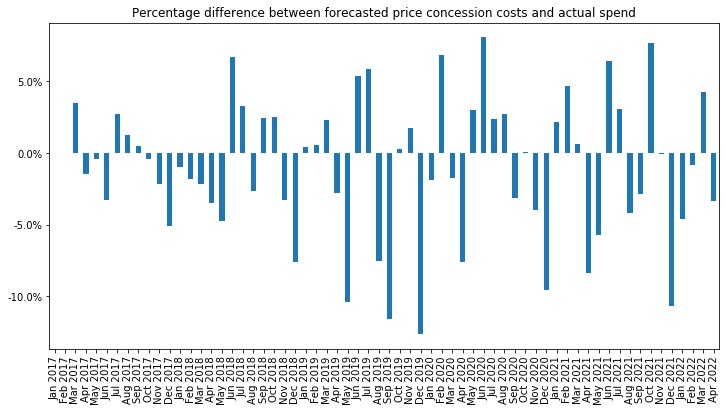

In [140]:
ax = ncso_days_sum_df.plot.bar(figsize = (12,6), y= ['percent_difference_work_days_adj'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_days_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [141]:
ncso_days_sum_df['percent_difference_work_days_adj'].std()

0.0490932864875552

In [142]:
ncso_sum_df.head(25)

,index,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference
0,0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,3.103501e+04,0.003877
1,1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,4.801772e+05,0.064686
2,2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-3.907127e+05,-0.044928
3,3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-9.213702e+04,-0.014621
4,4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,9.696994e+05,0.078467
5,5,2017-06-01,39206231.0,3.695928e+07,3.115332e+07,3.250022e+07,2.891029e+07,-3.589939e+06,-0.110459
6,6,2017-07-01,44137873.5,4.468539e+07,3.789183e+07,3.566866e+07,3.516362e+07,-5.050438e+05,-0.014159
7,7,2017-08-01,108983792.0,1.071542e+08,5.084205e+07,4.660851e+07,4.718142e+07,5.729093e+05,0.012292
8,8,2017-09-01,270504489.5,2.698667e+08,6.296214e+07,5.813965e+07,5.842886e+07,2.892112e+05,0.004974
9,9,2017-10-01,403394513.5,3.999540e+08,7.661345e+07,7.140800e+07,7.109729e+07,-3.107094e+05,-0.004351


adding in better discount

In [143]:
discount_df = pd.read_csv('../data/bsa_nadp.txt', engine = 'python')
discount_df['rx_month'] = discount_df['rx_month'].astype('datetime64[ns]')

In [144]:
discount_df.head()

,rx_month,NADP
0,2022-04-01,6.43
1,2022-03-01,6.48
2,2022-02-01,6.38
3,2022-01-01,6.45
4,2021-12-01,6.65


In [145]:
ncso_discount_sum_df = pd.merge(ncso_days_sum_df, discount_df, on='rx_month')

In [146]:
ncso_discount_sum_df.head(200)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,workdays,dispdays,dispdaysshift,predicted_cost_work_days_adj,difference_work_day_adj,percent_difference_work_days_adj,NADP
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,20,24,NaN,NaN,NaN,NaN,7.42
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,19,23,NaN,NaN,NaN,NaN,7.33
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928,2017,3,22,26,24.0,8.997872e+06,3.014313e+05,0.034661,7.28
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621,2017,4,18,23,23.0,6.209400e+06,-9.213702e+04,-0.014621,7.42
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467,2017,5,20,24,26.0,1.230253e+07,-5.551118e+04,-0.004492,7.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-12-01,126868151.0,1.217257e+08,1.859387e+07,1.782933e+07,1.725511e+07,-574220.061991,-0.032206,2021,12,20,24,26.0,1.592780e+07,-1.901537e+06,-0.106652,6.65
60,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970,2022,1,19,24,25.0,2.130683e+07,-1.021091e+06,-0.045732,6.45
61,2022-02-01,191607921.0,2.078266e+08,2.157544e+07,1.934735e+07,2.002201e+07,674661.031326,0.034871,2022,2,19,23,24.0,1.918776e+07,-1.595893e+05,-0.008249,6.38
62,2022-03-01,200562460.0,1.885463e+08,2.507782e+07,2.418932e+07,2.327222e+07,-917099.897847,-0.037913,2022,3,22,26,24.0,2.521157e+07,1.022252e+06,0.042260,6.48


In [147]:
ncso_discount_sum_df['NADP_shift']=ncso_discount_sum_df['NADP'].shift(2)

In [148]:
ncso_discount_sum_df.head(200)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,workdays,dispdays,dispdaysshift,predicted_cost_work_days_adj,difference_work_day_adj,percent_difference_work_days_adj,NADP,NADP_shift
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,20,24,NaN,NaN,NaN,NaN,7.42,NaN
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,19,23,NaN,NaN,NaN,NaN,7.33,NaN
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928,2017,3,22,26,24.0,8.997872e+06,3.014313e+05,0.034661,7.28,7.42
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621,2017,4,18,23,23.0,6.209400e+06,-9.213702e+04,-0.014621,7.42,7.33
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467,2017,5,20,24,26.0,1.230253e+07,-5.551118e+04,-0.004492,7.30,7.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-12-01,126868151.0,1.217257e+08,1.859387e+07,1.782933e+07,1.725511e+07,-574220.061991,-0.032206,2021,12,20,24,26.0,1.592780e+07,-1.901537e+06,-0.106652,6.65,6.81
60,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970,2022,1,19,24,25.0,2.130683e+07,-1.021091e+06,-0.045732,6.45,6.73
61,2022-02-01,191607921.0,2.078266e+08,2.157544e+07,1.934735e+07,2.002201e+07,674661.031326,0.034871,2022,2,19,23,24.0,1.918776e+07,-1.595893e+05,-0.008249,6.38,6.65
62,2022-03-01,200562460.0,1.885463e+08,2.507782e+07,2.418932e+07,2.327222e+07,-917099.897847,-0.037913,2022,3,22,26,24.0,2.521157e+07,1.022252e+06,0.042260,6.48,6.45


In [149]:
ncso_discount_sum_df['predicted_cost_work_days_adj_nadp']=(ncso_discount_sum_df['dispdays']/ncso_discount_sum_df['dispdaysshift'])*ncso_discount_sum_df['predicted_NIC']*(1-(ncso_discount_sum_df['NADP_shift']/100))
ncso_discount_sum_df['difference_work_day_adj_nadp']=ncso_discount_sum_df['predicted_cost_work_days_adj_nadp']-ncso_discount_sum_df['actual_cost']
ncso_discount_sum_df['percent_difference_work_days_adj_nadp']=ncso_discount_sum_df['difference_work_day_adj_nadp']/ncso_discount_sum_df['actual_cost']

In [150]:
ncso_discount_sum_df.head(40)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,...,dispdays,dispdaysshift,predicted_cost_work_days_adj,difference_work_day_adj,percent_difference_work_days_adj,NADP,NADP_shift,predicted_cost_work_days_adj_nadp,difference_work_day_adj_nadp,percent_difference_work_days_adj_nadp
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,3.103501e+04,0.003877,2017,1,...,24,NaN,NaN,NaN,NaN,7.42,NaN,NaN,NaN,NaN
1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,4.801772e+05,0.064686,2017,2,...,23,NaN,NaN,NaN,NaN,7.33,NaN,NaN,NaN,NaN
2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-3.907127e+05,-0.044928,2017,3,...,26,24.0,8.997872e+06,3.014313e+05,0.034661,7.28,7.42,8.976541e+06,2.801002e+05,0.032209
3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-9.213702e+04,-0.014621,2017,4,...,23,23.0,6.209400e+06,-9.213702e+04,-0.014621,7.42,7.33,6.200702e+06,-1.008355e+05,-0.016002
4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,9.696994e+05,0.078467,2017,5,...,24,26.0,1.230253e+07,-5.551118e+04,-0.004492,7.30,7.28,1.229192e+07,-6.611680e+04,-0.005350
5,2017-06-01,39206231.0,3.695928e+07,3.115332e+07,3.250022e+07,2.891029e+07,-3.589939e+06,-0.110459,2017,6,...,25,23.0,3.142422e+07,-1.076001e+06,-0.033108,7.38,7.42,3.134973e+07,-1.150499e+06,-0.035400
6,2017-07-01,44137873.5,4.468539e+07,3.789183e+07,3.566866e+07,3.516362e+07,-5.050438e+05,-0.014159,2017,7,...,25,24.0,3.662877e+07,9.601070e+05,0.026917,7.48,7.30,3.658930e+07,9.206364e+05,0.025811
7,2017-08-01,108983792.0,1.071542e+08,5.084205e+07,4.660851e+07,4.718142e+07,5.729093e+05,0.012292,2017,8,...,25,25.0,4.718142e+07,5.729093e+05,0.012292,7.47,7.38,4.708990e+07,4.813937e+05,0.010328
8,2017-09-01,270504489.5,2.698667e+08,6.296214e+07,5.813965e+07,5.842886e+07,2.892112e+05,0.004974,2017,9,...,25,25.0,5.842886e+07,2.892112e+05,0.004974,7.37,7.48,5.825257e+07,1.129172e+05,0.001942
9,2017-10-01,403394513.5,3.999540e+08,7.661345e+07,7.140800e+07,7.109729e+07,-3.107094e+05,-0.004351,2017,10,...,25,25.0,7.109729e+07,-3.107094e+05,-0.004351,7.43,7.47,7.089043e+07,-5.175657e+05,-0.007248


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

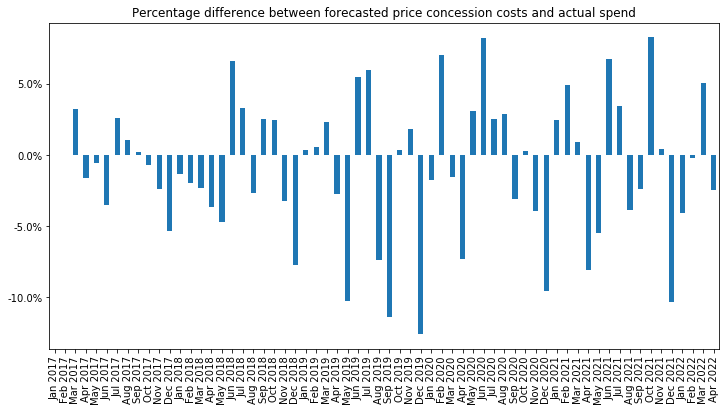

In [151]:
ax = ncso_discount_sum_df.plot.bar(figsize = (12,6), y= ['percent_difference_work_days_adj_nadp'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_discount_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [152]:
ncso_discount_sum_df['perc_difference'].std()

0.03244157151945177

add in average item weighting


In [210]:
sql = """
select extract (month from rx.month) as mon, sum(rx.items /total_rx.total_items)/(1/12) as proportion 
from hscic.normalised_prescribing as rx,  (SELECT sum(items) as total_items FROM hscic.normalised_prescribing where month between'2017-03-01' AND '2020-02-01' and substr(bnf_code,0,2) IN ('01','02','03','04','06','10'))AS total_rx
where month between'2017-03-01' AND '2020-02-01' and substr(bnf_code,0,2) IN ('01','02','03','04','06','10')
group by mon
"""

exportfile = os.path.join("..","data","annual_profile_df.csv")
annual_profile_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False)

Downloading: 100%|██████████| 12/12 [00:00<00:00, 77.94rows/s]


In [211]:
annual_profile_df.head(13)

,mon,proportion
0,11,1.006917
1,2,0.932481
2,3,1.014386
3,12,1.012403
4,10,1.028503
5,5,1.023824
6,6,0.994650
7,9,0.972565
8,4,0.960839
9,8,1.023237


In [212]:
ncso_profile_sum_new2_df = pd.merge(ncso_discount_sum_df, annual_profile_df,  on='mon')

In [213]:
ncso_profile_sum_new2_df.head(13)

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,...,dispdaysshift,predicted_cost_work_days_adj,difference_work_day_adj,percent_difference_work_days_adj,NADP,NADP_shift,predicted_cost_work_days_adj_nadp,difference_work_day_adj_nadp,percent_difference_work_days_adj_nadp,proportion
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,...,NaN,NaN,NaN,NaN,7.42,NaN,NaN,NaN,NaN,1.032089
1,2018-01-01,349491472.0,3.472209e+08,3.608230e+07,3.381102e+07,3.348437e+07,-326643.573965,-0.009661,2018,1,...,25.0,3.348437e+07,-3.266436e+05,-0.009661,7.33,7.52,3.336891e+07,-442106.930935,-0.013076,1.032089
2,2019-01-01,250674796.5,2.281480e+08,3.759760e+07,3.475090e+07,3.489057e+07,139668.863250,0.004019,2019,1,...,25.0,3.489057e+07,1.396689e+05,0.004019,7.19,7.23,3.487929e+07,128389.583277,0.003695,1.032089
3,2020-01-01,122895351.0,9.362473e+07,1.390150e+07,1.315177e+07,1.290059e+07,-251182.004389,-0.019099,2020,1,...,25.0,1.290059e+07,-2.511820e+05,-0.019099,7.02,7.07,1.291866e+07,-233110.059227,-0.017725,1.032089
4,2021-01-01,101597426.0,1.026682e+08,1.217417e+07,1.151672e+07,1.129763e+07,-219090.994304,-0.019024,2021,1,...,24.0,1.176836e+07,2.516434e+05,0.021850,6.92,6.98,1.179626e+07,279542.570410,0.024273,1.032089
5,2022-01-01,193354378.0,2.016004e+08,2.391661e+07,2.232792e+07,2.219461e+07,-133306.373752,-0.005970,2022,1,...,25.0,2.130683e+07,-1.021091e+06,-0.045732,6.45,6.73,2.141474e+07,-913179.148021,-0.040899,1.032089
6,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686,2017,2,...,NaN,NaN,NaN,NaN,7.33,NaN,NaN,NaN,NaN,0.932481
7,2018-02-01,258818252.5,2.738388e+08,2.314849e+07,2.096620e+07,2.148180e+07,515593.060766,0.024592,2018,2,...,24.0,2.058672e+07,-3.794819e+05,-0.018100,7.31,7.37,2.054901e+07,-417194.597355,-0.019898,0.932481
8,2019-02-01,244504526.5,2.380067e+08,3.539543e+07,3.265924e+07,3.284696e+07,187710.549464,0.005748,2019,2,...,23.0,3.284696e+07,1.877105e+05,0.005748,7.14,7.18,3.285403e+07,194789.634684,0.005964,0.932481
9,2020-02-01,119887451.0,9.948796e+07,1.476963e+07,1.338989e+07,1.370621e+07,316326.166753,0.023624,2020,2,...,23.0,1.430214e+07,9.122485e+05,0.068130,6.92,7.05,1.432525e+07,935366.172351,0.069856,0.932481


In [214]:
ncso_profile_sum_new2_df['predicted_cost_work_days_adj_prop']=ncso_profile_sum_new2_df['predicted_cost_work_days_adj_nadp']*ncso_profile_sum_new2_df['proportion']
ncso_profile_sum_new2_df['difference_work_day_adj_prop']=ncso_profile_sum_new2_df['predicted_cost_work_days_adj_prop']-ncso_profile_sum_new2_df['actual_cost']
ncso_profile_sum_new2_df['percent_difference_work_days_adj_prop']=ncso_profile_sum_new2_df['difference_work_day_adj_prop']/ncso_profile_sum_new2_df['actual_cost']

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

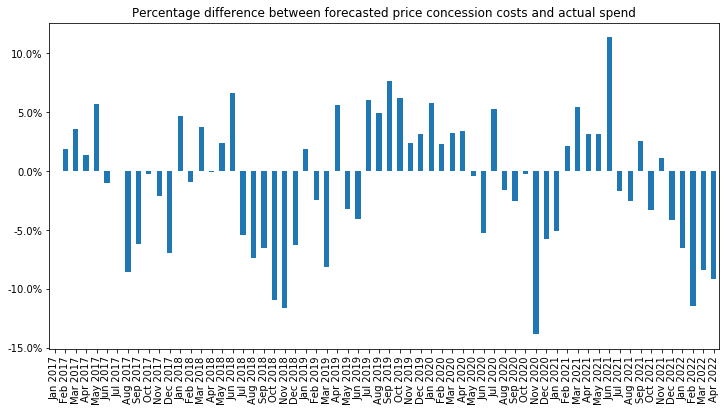

In [215]:
ax = ncso_profile_sum_new2_df.plot.bar(figsize = (12,6), y= ['percent_difference_work_days_adj_prop'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_discount_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [216]:
ncso_profile_sum_new2_df.head()

,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference,year,mon,...,percent_difference_work_days_adj,NADP,NADP_shift,predicted_cost_work_days_adj_nadp,difference_work_day_adj_nadp,percent_difference_work_days_adj_nadp,proportion,predicted_cost_work_days_adj_prop,difference_work_day_adj_prop,percent_difference_work_days_adj_prop
0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877,2017,1,...,NaN,7.42,NaN,NaN,NaN,NaN,1.032089,NaN,NaN,NaN
1,2018-01-01,349491472.0,3.472209e+08,3.608230e+07,3.381102e+07,3.348437e+07,-326643.573965,-0.009661,2018,1,...,-0.009661,7.33,7.52,3.336891e+07,-442106.930935,-0.013076,1.032089,3.443970e+07,6.286815e+05,0.018594
2,2019-01-01,250674796.5,2.281480e+08,3.759760e+07,3.475090e+07,3.489057e+07,139668.863250,0.004019,2019,1,...,0.004019,7.19,7.23,3.487929e+07,128389.583277,0.003695,1.032089,3.599855e+07,1.247645e+06,0.035903
3,2020-01-01,122895351.0,9.362473e+07,1.390150e+07,1.315177e+07,1.290059e+07,-251182.004389,-0.019099,2020,1,...,-0.019099,7.02,7.07,1.291866e+07,-233110.059227,-0.017725,1.032089,1.333321e+07,1.814420e+05,0.013796
4,2021-01-01,101597426.0,1.026682e+08,1.217417e+07,1.151672e+07,1.129763e+07,-219090.994304,-0.019024,2021,1,...,0.021850,6.92,6.98,1.179626e+07,279542.570410,0.024273,1.032089,1.217479e+07,6.580775e+05,0.057141


In [217]:
ncso_sum_df.head()

,index,rx_month,quantity,rolling_ave_quantity,predicted_NIC,actual_cost,predicted_actual_cost,difference,perc_difference
0,0,2017-01-01,34845972.0,3.574102e+07,8.660356e+06,8.005775e+06,8.036810e+06,31035.011007,0.003877
1,1,2017-02-01,32066632.0,3.418921e+07,8.516589e+06,7.423218e+06,7.903395e+06,480177.176313,0.064686
2,2,2017-03-01,35641955.0,3.318341e+07,8.950138e+06,8.696441e+06,8.305728e+06,-390712.696795,-0.044928
3,3,2017-04-01,31322530.0,3.247609e+07,6.691164e+06,6.301537e+06,6.209400e+06,-92137.023580,-0.014621
4,4,2017-05-01,34678515.0,3.425135e+07,1.436179e+07,1.235804e+07,1.332774e+07,969699.401963,0.078467


In [218]:
ncso_disc_sum_df = pd.merge(ncso_sum_df, discount_df, on='rx_month')
ncso_disc_sum_df=ncso_disc_sum_df.drop(columns=['quantity','rolling_ave_quantity', 'predicted_actual_cost','difference','perc_difference'])

In [219]:
ncso_disc_sum_df['predicted_act_cost_nadp']=ncso_disc_sum_df['predicted_NIC']-(ncso_disc_sum_df['predicted_NIC']*(ncso_disc_sum_df['NADP']/100))
ncso_disc_sum_df['difference_act_cost_nadp']=ncso_disc_sum_df['predicted_act_cost_nadp']-ncso_disc_sum_df['actual_cost']
ncso_disc_sum_df['percent_predicted_act_cost_nadp']=ncso_disc_sum_df['difference_act_cost_nadp']/ncso_disc_sum_df['actual_cost']
ncso_disc_sum_df['mon'] = pd.DatetimeIndex(ncso_disc_sum_df['rx_month']).month
ncso_disc_sum_df.head()

,index,rx_month,predicted_NIC,actual_cost,NADP,predicted_act_cost_nadp,difference_act_cost_nadp,percent_predicted_act_cost_nadp,mon
0,0,2017-01-01,8.660356e+06,8.005775e+06,7.42,8.017757e+06,11982.228834,0.001497,1
1,1,2017-02-01,8.516589e+06,7.423218e+06,7.33,7.892323e+06,469105.610138,0.063194,2
2,2,2017-03-01,8.950138e+06,8.696441e+06,7.28,8.298568e+06,-397872.807240,-0.045751,3
3,3,2017-04-01,6.691164e+06,6.301537e+06,7.42,6.194680e+06,-106857.584756,-0.016957,4
4,4,2017-05-01,1.436179e+07,1.235804e+07,7.30,1.331338e+07,955337.615836,0.077305,5


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

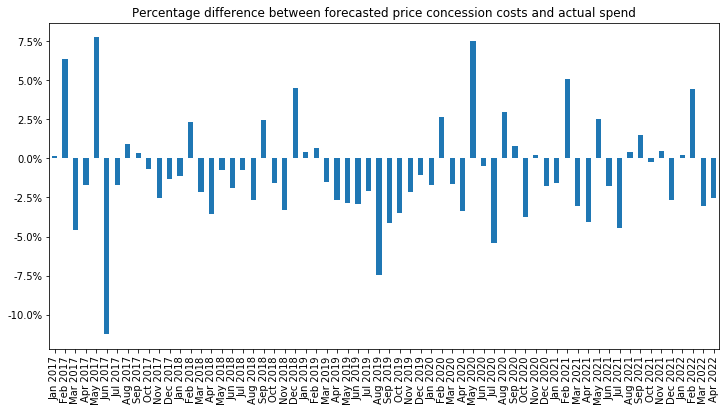

In [220]:
ax = ncso_disc_sum_df.plot.bar(figsize = (12,6), y= ['percent_predicted_act_cost_nadp'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [221]:
ncso_disc_sum_df = pd.merge(ncso_disc_sum_df, annual_profile_df,  on='mon')

In [222]:
ncso_disc_sum_df.head()

,index,rx_month,predicted_NIC,actual_cost,NADP,predicted_act_cost_nadp,difference_act_cost_nadp,percent_predicted_act_cost_nadp,mon,proportion
0,0,2017-01-01,8.660356e+06,8.005775e+06,7.42,8.017757e+06,11982.228834,0.001497,1,1.032089
1,12,2018-01-01,3.608230e+07,3.381102e+07,7.33,3.343747e+07,-373550.562734,-0.011048,1,1.032089
2,24,2019-01-01,3.759760e+07,3.475090e+07,7.19,3.489433e+07,143428.623241,0.004127,1,1.032089
3,36,2020-01-01,1.390150e+07,1.315177e+07,7.02,1.292561e+07,-226159.311087,-0.017196,1,1.032089
4,48,2021-01-01,1.217417e+07,1.151672e+07,6.92,1.133171e+07,-185003.328436,-0.016064,1,1.032089


In [223]:
ncso_disc_sum_df['predicted_actual_cost_prop']=ncso_disc_sum_df['predicted_act_cost_nadp']*ncso_disc_sum_df['proportion']
ncso_disc_sum_df['difference_predicted_actual_cost_prop']=ncso_disc_sum_df['predicted_actual_cost_prop']-ncso_disc_sum_df['actual_cost']
ncso_disc_sum_df['percent_predicted_actual_cost_prop']=ncso_disc_sum_df['difference_predicted_actual_cost_prop']/ncso_disc_sum_df['actual_cost']

In [224]:
ncso_disc_sum_df.head()

,index,rx_month,predicted_NIC,actual_cost,NADP,predicted_act_cost_nadp,difference_act_cost_nadp,percent_predicted_act_cost_nadp,mon,proportion,predicted_actual_cost_prop,difference_predicted_actual_cost_prop,percent_predicted_actual_cost_prop
0,0,2017-01-01,8.660356e+06,8.005775e+06,7.42,8.017757e+06,11982.228834,0.001497,1,1.032089,8.275042e+06,2.692673e+05,0.033634
1,12,2018-01-01,3.608230e+07,3.381102e+07,7.33,3.343747e+07,-373550.562734,-0.011048,1,1.032089,3.451045e+07,6.994378e+05,0.020687
2,24,2019-01-01,3.759760e+07,3.475090e+07,7.19,3.489433e+07,143428.623241,0.004127,1,1.032089,3.601407e+07,1.263167e+06,0.036349
3,36,2020-01-01,1.390150e+07,1.315177e+07,7.02,1.292561e+07,-226159.311087,-0.017196,1,1.032089,1.334039e+07,1.886158e+05,0.014341
4,48,2021-01-01,1.217417e+07,1.151672e+07,6.92,1.133171e+07,-185003.328436,-0.016064,1,1.032089,1.169534e+07,1.786246e+05,0.015510


Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

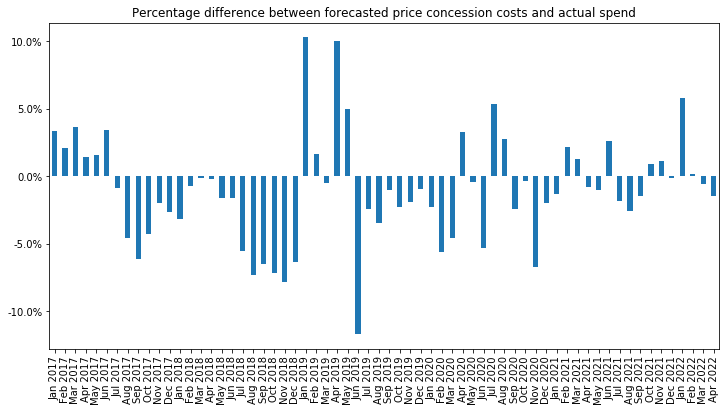

In [225]:
ax = ncso_disc_sum_df.plot.bar(figsize = (12,6), y= ['percent_predicted_actual_cost_prop'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [226]:
ncso_disc_sum_df['percent_predicted_actual_cost_prop'].std()

0.04017613948180118